In [35]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [37]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import warnings
warnings.filterwarnings('ignore')

In [39]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [41]:
train.head(5)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [42]:
train.tail(5)

,date,store,item,sales
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


In [43]:
train['date'] = pd.to_datetime(train['date'], format="%Y-%m-%d")

In [44]:
print('Start: ', train['date'].min().date())
print('End: ', train['date'].max().date())

Start:  2013-01-01
End:  2017-12-31


In [45]:
train.groupby(["store","item"]).nunique().head(5)

date  sales
store item             
1     1     1826     41
      2     1826     90
      3     1826     59
      4     1826     39
      5     1826     34

In [46]:
def expand_df(df):
    data = df.copy()
    
    data['day'] = data.date.dt.day
    data['month'] = data.date.dt.month
    data['year'] = data.date.dt.year
    data['dayofweek'] = data.date.dt.dayofweek
    return data

train = expand_df(train)
train.head()

,date,store,item,sales,day,month,year,dayofweek
0,2013-01-01,1,1,13,1,1,2013,1
1,2013-01-02,1,1,11,2,1,2013,2
2,2013-01-03,1,1,14,3,1,2013,3
3,2013-01-04,1,1,13,4,1,2013,4
4,2013-01-05,1,1,10,5,1,2013,5


In [47]:
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
store_daily_sales = train.groupby(['store', 'date'], as_index=False)['sales'].sum()
item_daily_sales = train.groupby(['item', 'date'], as_index=False)['sales'].sum()

In [48]:
daily_sales.head()

,date,sales
0,2013-01-01,13696
1,2013-01-02,13678
2,2013-01-03,14488
3,2013-01-04,15677
4,2013-01-05,16237


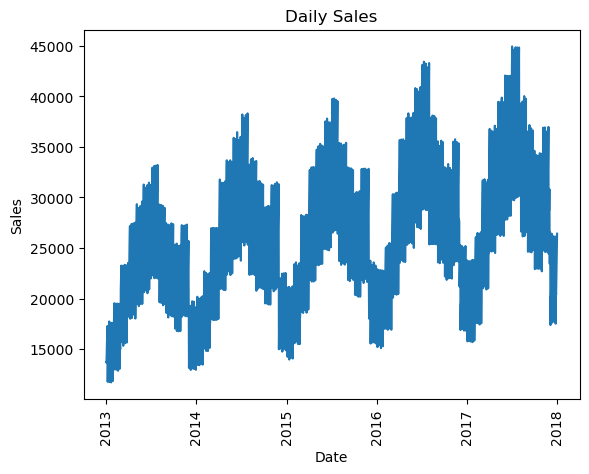

In [49]:
plt.plot(daily_sales['date'], daily_sales['sales'])
plt.title('Daily Sales')
plt.ylabel('Sales')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.show()

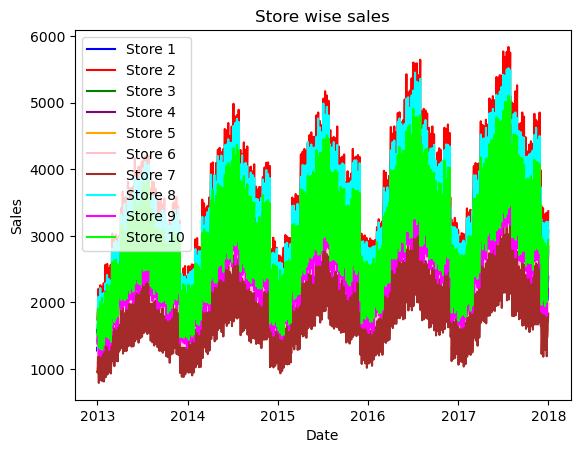

In [50]:
store_colors = {
    1: 'blue',
    2: 'red',
    3: 'green',
    4: 'purple',
    5: 'orange',
    6: 'pink',
    7: 'brown',
    8: 'cyan',
    9: 'magenta',
    10: 'lime'
}

fig, ax = plt.subplots()
for store, color in store_colors.items():
    store_data = store_daily_sales[store_daily_sales['store'] == store]
    ax.plot(store_data['date'], store_data['sales'], label=f'Store {store}', color=color)

# Set labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Store wise sales')
ax.legend()

# Show the plot
plt.show()

In [51]:
item_sales = train.groupby(['item', 'date'], as_index=False)['sales'].sum()
day_sales = train.groupby(['day', 'date'], as_index=False)['sales'].sum()
month_sales = train.groupby(['month', 'date'], as_index=False)['sales'].sum()
year_sales = train.groupby(['year', 'date'], as_index=False)['sales'].sum()
day_of_week_sales = train.groupby(['dayofweek', 'date'], as_index=False)['sales'].sum()

In [52]:
item_sales.head()

,item,date,sales
0,1,2013-01-01,133
1,1,2013-01-02,99
2,1,2013-01-03,127
3,1,2013-01-04,145
4,1,2013-01-05,149


Text(0.5, 1.0, 'Sales vs. Date by Item')

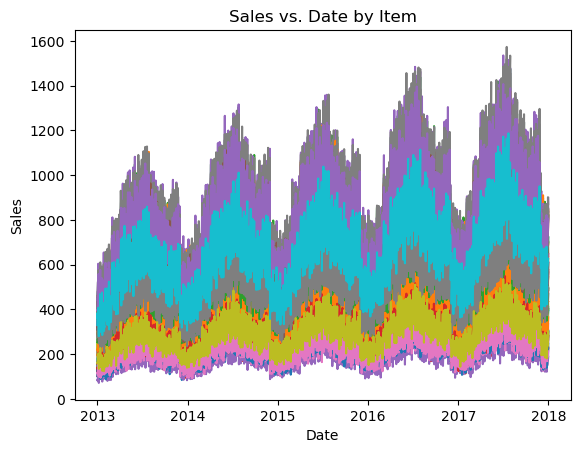

In [53]:
unique_items = item_sales['item'].unique()

# Create a figure and axis
fig, ax = plt.subplots()

# Iterate through unique items and plot sales data for each item
for item in unique_items:
    item_data = item_sales[item_sales['item'] == item]
    ax.plot(item_data['date'], item_data['sales'], label=f'Item {item}')

# Set labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Sales vs. Date by Item')

In [54]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

<Figure size 640x480 with 0 Axes>

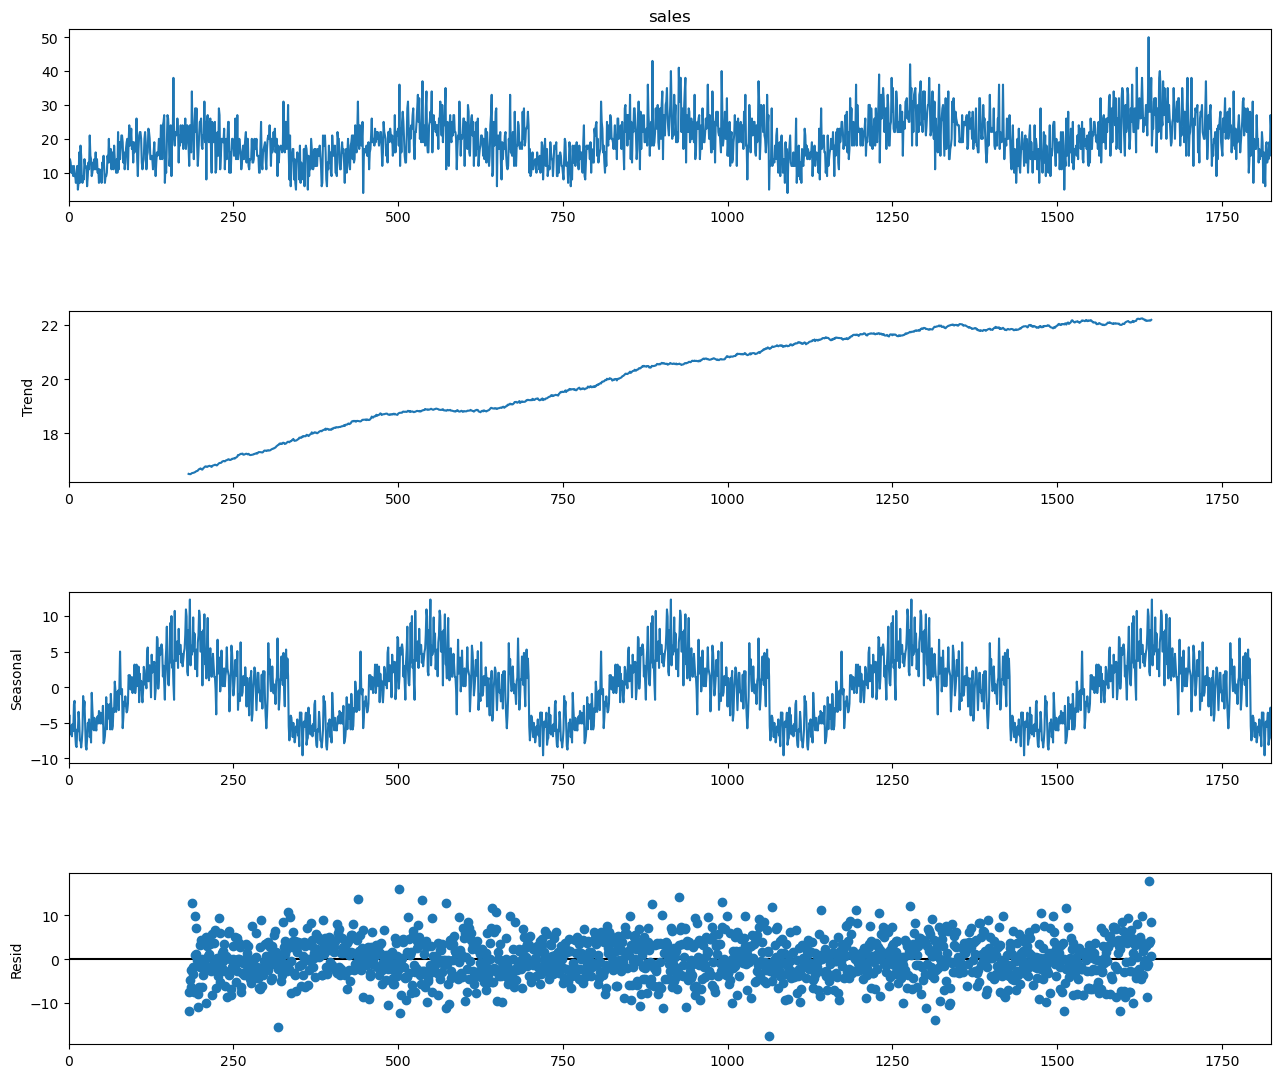

In [55]:
# Lets decompose for data of smaller size. Here I will take data having item and store equal to 1.

train_item1 = train[train['item']==1]
train_final = train_item1[train_item1['store']==1]


result = sm.tsa.seasonal_decompose(train_final['sales'], model='additive', period=365) #Seasonal decomposition using moving averages

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(14, 12)

In [56]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

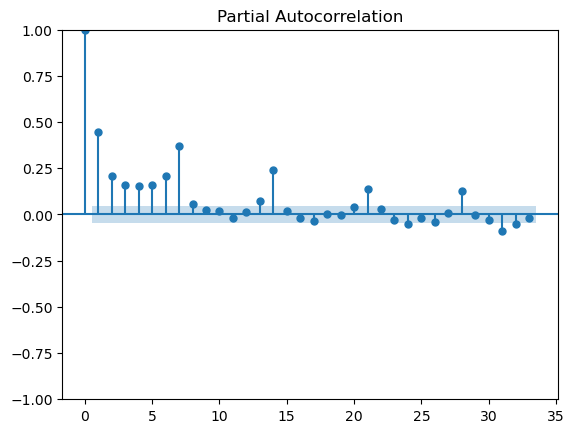

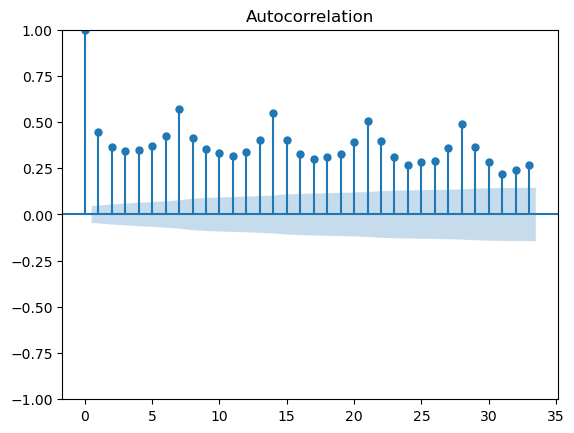

In [57]:
plot_pacf(train_final['sales']);
plot_acf(train_final['sales']);

In [58]:
from statsmodels.tsa.stattools import adfuller
ad_fuller_result = adfuller(train_final['sales'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.157670556332793
p-value: 0.022569380626572252


In [59]:
first_diff = train_final.sales - train_final.sales.shift(1)
first_diff = first_diff.dropna(inplace = False)
print(first_diff.head())
print()

ad_fuller_result = adfuller(first_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

1   -2.0
2    3.0
3   -1.0
4   -3.0
5    2.0
Name: sales, dtype: float64

ADF Statistic: -12.67679388604747
p-value: 1.210927632043708e-23


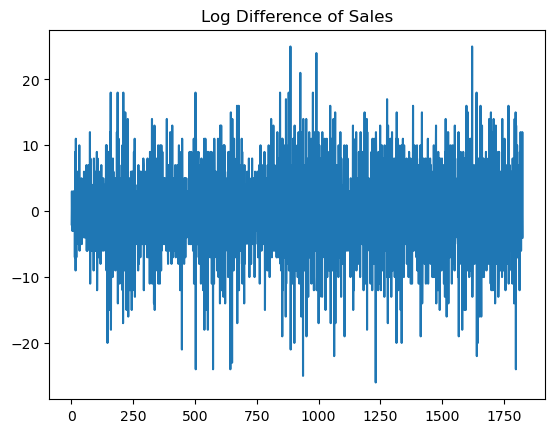

In [60]:
plt.plot(first_diff)
plt.title("Log Difference of Sales")
plt.show()

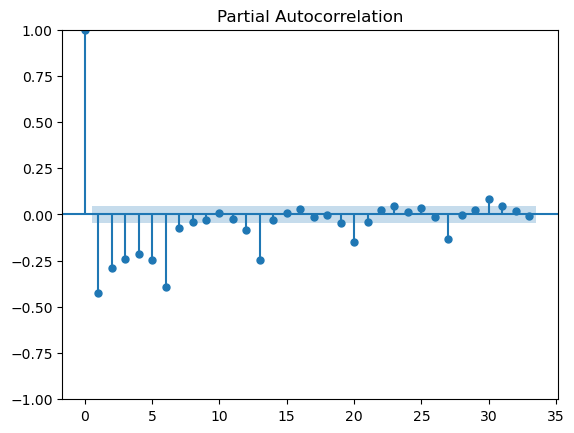

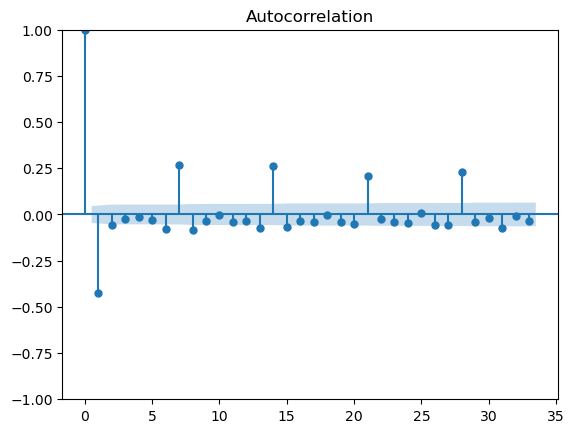

In [61]:
plot_pacf(first_diff);
plot_acf(first_diff);

Autocorrelation measures the linear relationship between an observation and its previous observations at different lags. Partial autocorrelation measures the direct linear relationship between an observation and its previous observations at a specific lag, excluding the contributions from intermediate lags.

## ARIMA

In [62]:
def optimize_ARIMA(endog, order_list):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        endog - the observed variable
    """
    
    results = []
    
    for order in order_list:
        try: 
            model = SARIMAX(endog, order=order, simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [63]:
from itertools import product

ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)
    
order_list[:10]

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (1, 1, 0),
 (1, 1, 1)]

In [64]:
result_df = optimize_ARIMA(train_final.sales, order_list)
result_df

,"(p, d, q)",AIC
0,"(6, 1, 7)",10899.422998
1,"(7, 1, 7)",10916.628192
2,"(5, 1, 5)",10997.700484
3,"(6, 1, 5)",11010.149547
4,"(4, 1, 7)",11018.554739
...,...,...
59,"(4, 1, 0)",11616.440522
60,"(3, 1, 0)",11701.431885
61,"(2, 1, 0)",11805.944671
62,"(1, 1, 0)",11963.116936


In [65]:
import statsmodels.api as sm
resDiff = sm.tsa.arma_order_select_ic(train_final.sales, max_ar=8, max_ma=8, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

ARMA(p,q) = (7, 7) is the best.


In [66]:
arima_model = SARIMAX(train_final.sales, order=(6,1,7), simple_differencing=False)
res = arima_model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1826
Model:               SARIMAX(6, 1, 7)   Log Likelihood               -5435.711
Date:                Tue, 06 Aug 2024   AIC                          10899.423
Time:                        19:54:42   BIC                          10976.554
Sample:                             0   HQIC                         10927.875
                               - 1826                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9830      0.012    -84.496      0.000      -1.006      -0.960
ar.L2         -0.9795      0.009   -103.394      0.000      -0.998      -0.961
ar.L3         -0.9822      0.009   -107.593      0.0

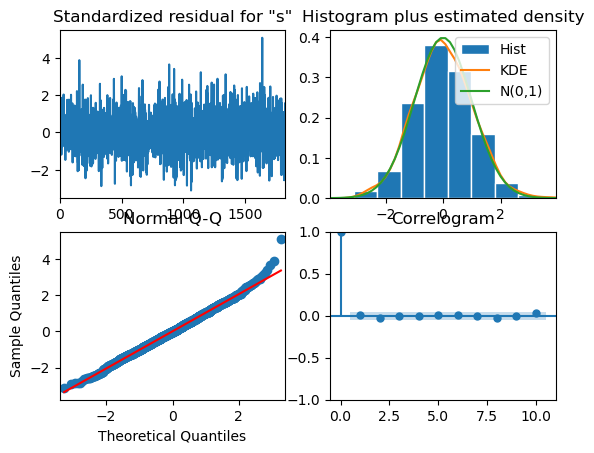

In [67]:
res.plot_diagnostics();

<AxesSubplot:>

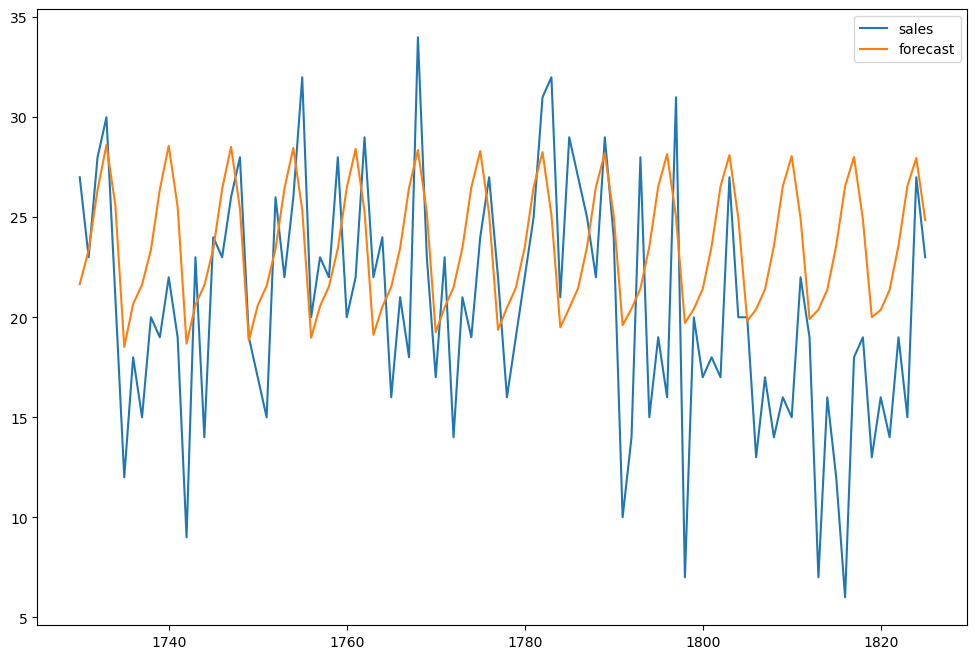

In [68]:
start_index = 1730
end_index = 1826
train['forecast'] = res.predict(start = start_index, end= end_index, dynamic= True)  
train[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))

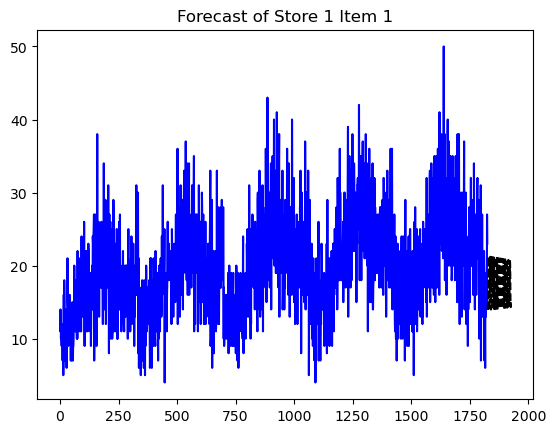

In [69]:
n_forecast =100
predict = res.get_prediction(end=arima_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

fig, ax = plt.subplots()
ax.plot(train_final.sales, 'blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')

ax.set(title='Forecast of Store 1 Item 1')
plt.show()

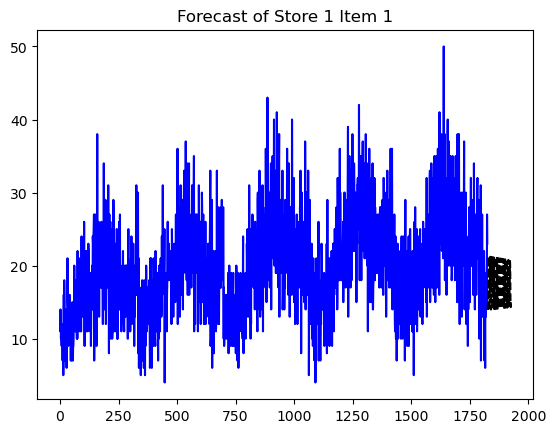

In [70]:
n_forecast =100
predict = res.get_prediction(end=arima_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

fig, ax = plt.subplots()
ax.plot(train_final.sales, 'blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')

ax.set(title='Forecast of Store 1 Item 1')
plt.show()

In [72]:
train_final['model'] = predict.predicted_mean
train_final.head(15)

,date,store,item,sales,day,month,year,dayofweek,model
0,2013-01-01,1,1,13,1,1,2013,1,0.000000
1,2013-01-02,1,1,11,2,1,2013,2,12.999747
2,2013-01-03,1,1,14,3,1,2013,3,11.882404
3,2013-01-04,1,1,13,4,1,2013,4,12.863047
4,2013-01-05,1,1,10,5,1,2013,5,12.870684
5,2013-01-06,1,1,12,6,1,2013,6,11.858255
6,2013-01-07,1,1,10,7,1,2013,0,12.115533
7,2013-01-08,1,1,9,8,1,2013,1,11.958020
8,2013-01-09,1,1,12,9,1,2013,2,11.359713
9,2013-01-10,1,1,9,10,1,2013,3,12.220158


In [73]:
mse = mean_squared_error(train_final['sales'], train_final['model'])
print(f'MSE: {mse}')

MSE: 22.62950398768548


### SARIMA

In [74]:
len(train_final.sales)

1826

In [75]:
best_model = SARIMAX(train_final.sales, order=(6,1,7), seasonal_order=(6,1,7,12), simple_differencing=False)
res = best_model.fit(disp=False)
print(res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              sales   No. Observations:                 1826
Model:             SARIMAX(6, 1, 7)x(6, 1, 7, 12)   Log Likelihood               -5441.545
Date:                            Tue, 06 Aug 2024   AIC                          10937.090
Time:                                    20:09:07   BIC                          11085.664
Sample:                                         0   HQIC                         10991.914
                                           - 1826                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9122      0.070    -13.001      0.000      -1.050      -0.775
ar.L2         -0.9287      0.029   

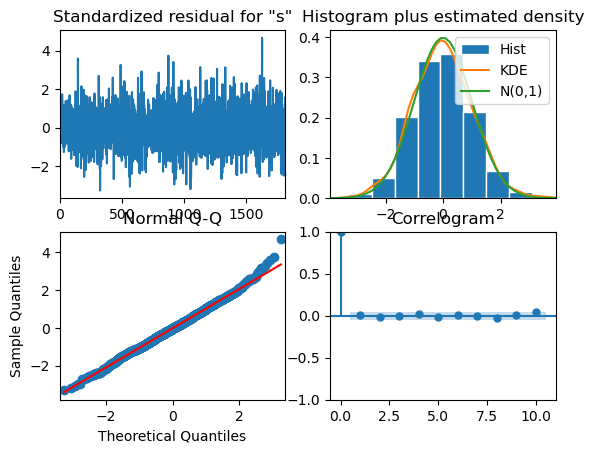

In [76]:
res.plot_diagnostics();

<AxesSubplot:>

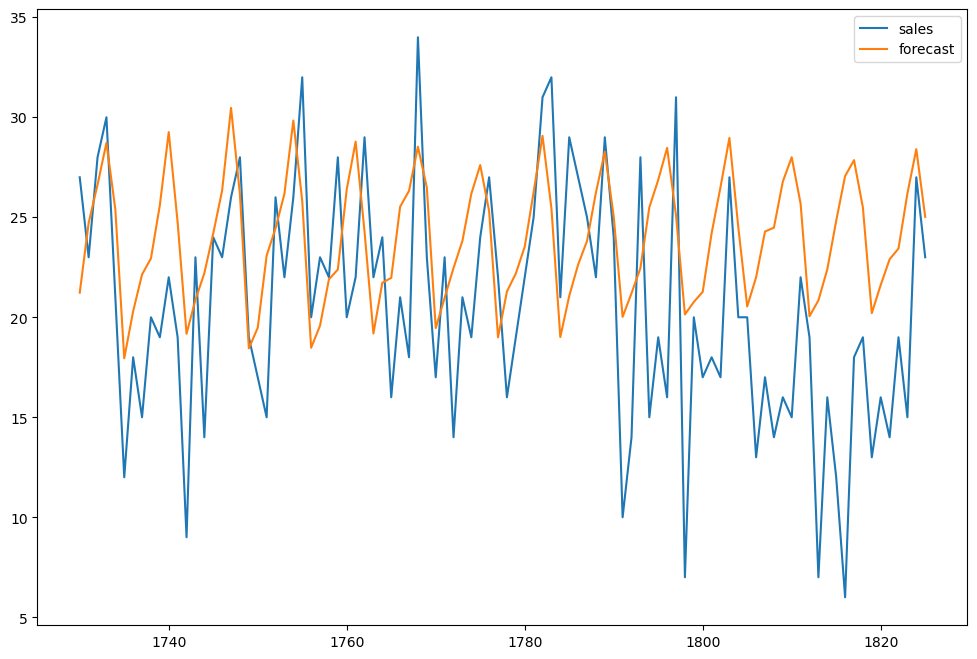

In [77]:
start_index = 1730
end_index = 1826
train['forecast'] = res.predict(start = start_index, end= end_index, dynamic= True)  
train[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))

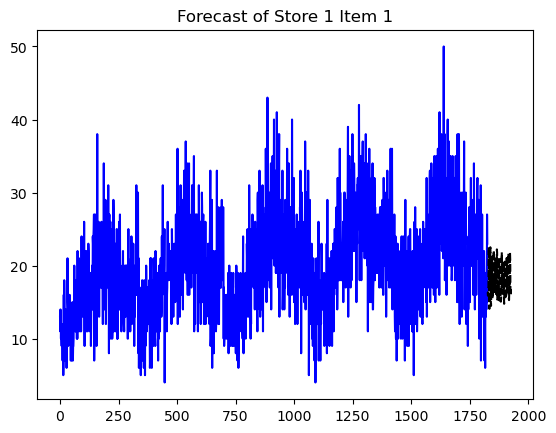

In [78]:
n_forecast =100
predict = res.get_prediction(end=arima_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

fig, ax = plt.subplots()
ax.plot(train_final.sales, 'blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')

ax.set(title='Forecast of Store 1 Item 1')
plt.show()

In [79]:
train_final['model'] = predict.predicted_mean
train_final.head(15)

,date,store,item,sales,day,month,year,dayofweek,model
0,2013-01-01,1,1,13,1,1,2013,1,0.000000
1,2013-01-02,1,1,11,2,1,2013,2,12.999753
2,2013-01-03,1,1,14,3,1,2013,3,11.000029
3,2013-01-04,1,1,13,4,1,2013,4,13.999907
4,2013-01-05,1,1,10,5,1,2013,5,13.000013
5,2013-01-06,1,1,12,6,1,2013,6,10.000092
6,2013-01-07,1,1,10,7,1,2013,0,11.999938
7,2013-01-08,1,1,9,8,1,2013,1,10.000147
8,2013-01-09,1,1,12,9,1,2013,2,9.000017
9,2013-01-10,1,1,9,10,1,2013,3,11.999911


In [80]:
mse = mean_squared_error(train_final['sales'], train_final['model'])
print(f'MSE: {mse}')

MSE: 23.44882421316901


SARIMA shows similar results, therefore trying SARIMAX or ARIMAX where we also consider exogenous variables

The only difference between ARIMA and ARIMAX is the addition of an exogenous (external) variable. The ARIMA model works on a single time series data (univariate) whereas ARIMAX uses multiple variables to include the external feature.

ARIMAX

In [81]:
buf = train[(train.item==1)&(train.store==1)].copy()

In [82]:
buf.head()

,date,store,item,sales,day,month,year,dayofweek,forecast
0,2013-01-01,1,1,13,1,1,2013,1,NaN
1,2013-01-02,1,1,11,2,1,2013,2,NaN
2,2013-01-03,1,1,14,3,1,2013,3,NaN
3,2013-01-04,1,1,13,4,1,2013,4,NaN
4,2013-01-05,1,1,10,5,1,2013,5,NaN


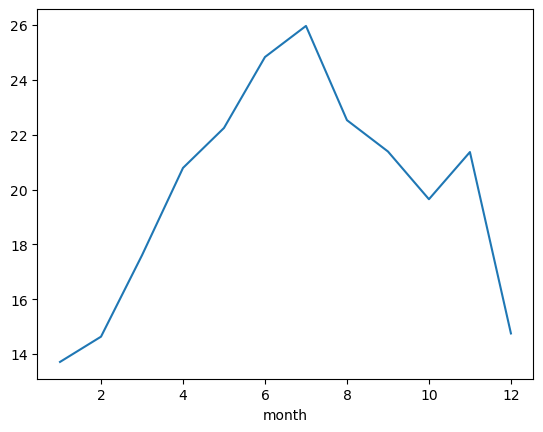

In [83]:
buf.groupby(buf.month).sales.mean().plot();plt.show()

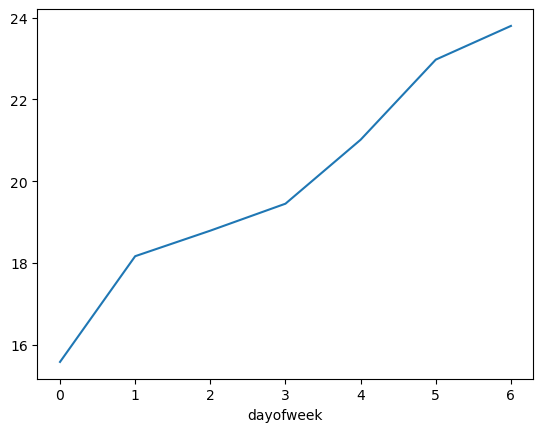

In [84]:
buf.groupby(buf.dayofweek).sales.mean().plot();plt.show()

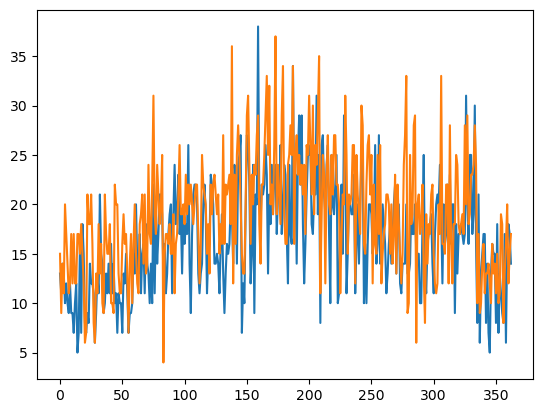

In [85]:
plt.plot(buf[0:363].sales.dropna().values)
plt.plot(buf[364:727].sales.dropna().values);plt.show()

In [86]:
month_dummies = pd.get_dummies(buf['month'])
month_dummies.columns = ['month-'+ str(m) for m in range(1,13)]

In [87]:
month_dummies.head()

,month-1,month-2,month-3,month-4,month-5,month-6,month-7,month-8,month-9,month-10,month-11,month-12
0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0


In [88]:
buf = pd.concat([buf, month_dummies], axis=1).drop(['month','forecast'],axis=1)

In [89]:
buf.head()

,date,store,item,sales,day,year,dayofweek,month-1,month-2,month-3,month-4,month-5,month-6,month-7,month-8,month-9,month-10,month-11,month-12
0,2013-01-01,1,1,13,1,2013,1,1,0,0,0,0,0,0,0,0,0,0,0
1,2013-01-02,1,1,11,2,2013,2,1,0,0,0,0,0,0,0,0,0,0,0
2,2013-01-03,1,1,14,3,2013,3,1,0,0,0,0,0,0,0,0,0,0,0
3,2013-01-04,1,1,13,4,2013,4,1,0,0,0,0,0,0,0,0,0,0,0
4,2013-01-05,1,1,10,5,2013,5,1,0,0,0,0,0,0,0,0,0,0,0


In [90]:
buf.columns

Index(['date', 'store', 'item', 'sales', 'day', 'year', 'dayofweek', 'month-1',
       'month-2', 'month-3', 'month-4', 'month-5', 'month-6', 'month-7',
       'month-8', 'month-9', 'month-10', 'month-11', 'month-12'],
      dtype='object')

In [91]:
week_dummies = pd.get_dummies(buf['dayofweek'])
week_dummies.columns = ['dayofweek-'+ str(w) for w in range(0,7)]
buf = pd.concat([buf, week_dummies], axis=1)
#Satday,Sunday
buf['weekend'] = (buf.dayofweek>4).astype(int)
buf = buf.drop(['dayofweek'],axis=1)

In [92]:
buf.head()

,date,store,item,sales,day,year,month-1,month-2,month-3,month-4,...,month-11,month-12,dayofweek-0,dayofweek-1,dayofweek-2,dayofweek-3,dayofweek-4,dayofweek-5,dayofweek-6,weekend
0,2013-01-01,1,1,13,1,2013,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,2013-01-02,1,1,11,2,2013,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,2013-01-03,1,1,14,3,2013,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,2013-01-04,1,1,13,4,2013,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2013-01-05,1,1,10,5,2013,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [93]:
buf['sales_shifted_728'] = buf.sales.shift(728)
buf['sales_shifted_364'] = buf.sales.shift(364)

In [96]:
buf.index = buf['date']

In [97]:
tr_end = '2017-09-30'
te_start,te_end = '2017-10-01','2017-12-31'

tra = buf['sales'][:tr_end].dropna()
tes = buf['sales'][te_start:te_end].dropna()

exog_train = buf.drop(['date','store','item','sales'],axis = 1)[:tr_end]
exog_test = buf.drop(['date', 'store','item','sales'],axis = 1)[te_start:te_end]

In [98]:
exog_train.shape

(1734, 24)

In [99]:
exog_train = exog_train.reindex(tra.index).fillna(0)
exog_test = exog_test.reindex(tes.index).fillna(0)

In [100]:
exog_train = exog_train.fillna(0)

In [101]:
print(tra.dtypes)
print(exog_train.dtypes)


int64
day                    int64
year                   int64
month-1                uint8
month-2                uint8
month-3                uint8
month-4                uint8
month-5                uint8
month-6                uint8
month-7                uint8
month-8                uint8
month-9                uint8
month-10               uint8
month-11               uint8
month-12               uint8
dayofweek-0            uint8
dayofweek-1            uint8
dayofweek-2            uint8
dayofweek-3            uint8
dayofweek-4            uint8
dayofweek-5            uint8
dayofweek-6            uint8
weekend                int32
sales_shifted_728    float64
sales_shifted_364    float64
dtype: object


In [102]:
exog_train = exog_train.astype(int)

In [103]:
best_model = SARIMAX(tra, order=(6,1,7), seasonal_order=(0,0,0,0), exog = exog_train,freq='D',enforce_stationarity=False, enforce_invertibility=False)
res = best_model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1734
Model:               SARIMAX(6, 1, 7)   Log Likelihood               -5016.542
Date:                Tue, 06 Aug 2024   AIC                          10109.085
Time:                        20:36:23   BIC                          10316.298
Sample:                    01-01-2013   HQIC                         10185.739
                         - 09-30-2017                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
day                   0.0163      0.012      1.336      0.181      -0.008       0.040
year                  0.5762      1.359      0.424      0.672      -2.087       3.239
month-1              -6.

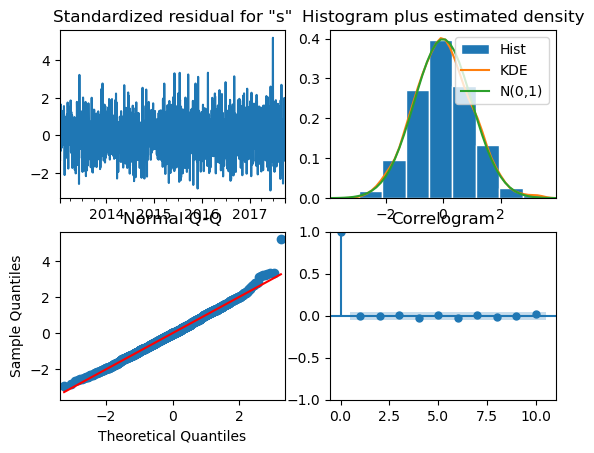

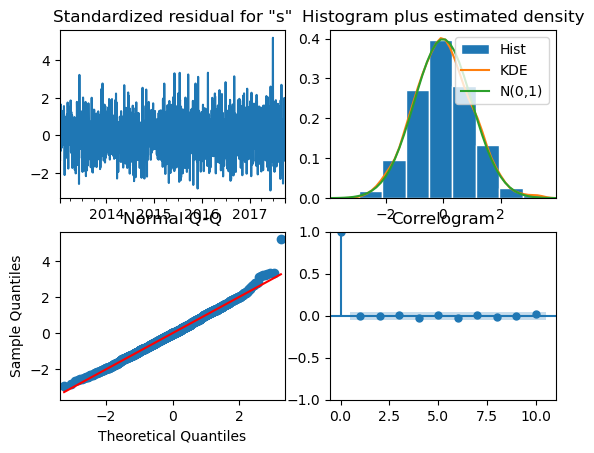

In [104]:
res.plot_diagnostics()

In [105]:
exog_test = exog_test.astype(int)  # Convert to float or appropriate numeric type

In [106]:
from sklearn.metrics import mean_squared_error
pred = res.predict(tr_end,te_end,exog = exog_test)[1:]
print('SARIMAX model MSE:{}'.format(mean_squared_error(tes,pred)))

SARIMAX model MSE:22.84279718490421


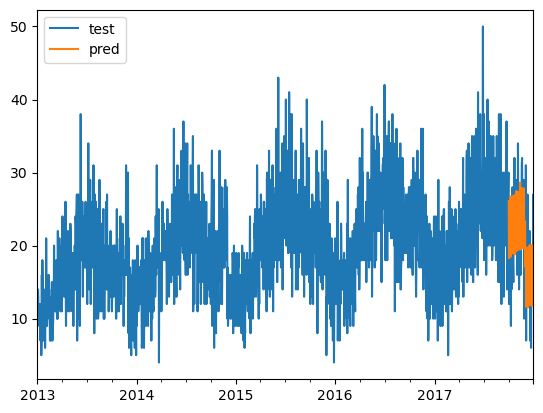

In [107]:
pd.DataFrame({'test':buf['sales'],'pred':pred}).plot();plt.show()

## PREDICTIONS

In [110]:
train = pd.read_csv('train.csv' ,parse_dates=['date'],index_col='date')
test = pd.read_csv('test.csv', parse_dates=['date'],index_col='date')
df = pd.concat([train,test],sort=True)
sample = pd.read_csv('sample_submission.csv')

In [111]:
df['month'] = df.index.month
month_dummies = pd.get_dummies(df['month'])
month_dummies.columns = ['month-'+ str(m) for m in range(1,13)]
df = pd.concat([df, month_dummies], axis=1).drop(['month'],axis=1)
#dayofweek one hot encoding
df['dayofweek'] = df.index.weekday
week_dummies = pd.get_dummies(df['dayofweek'])
week_dummies.columns = ['dayofweek-'+ str(w) for w in range(0,7)]
df = pd.concat([df, week_dummies], axis=1).drop(['dayofweek'],axis=1)
#Satday,Sunday
df['weekend'] = (df.index.dayofweek>4).astype(int)#Satday,Sunday

#shifts
shifts = [364,728]
for s in shifts:
    df['store_item_shifted-'+str(s)] = df.groupby(["item","store"])['sales'].transform(lambda x:x.shift(s))

Checking for one Store and one item

In [112]:
results = []
tr_start,tr_end = '2015-01-01','2017-09-30'
te_start,te_end = '2017-10-01','2017-12-31'
for i in range(1,2):
    for s in range(1,2):
        buf = df[(df.item==i)&(df.store==s)].copy()
        target_exog = buf[te_start:].drop(['id','store','item','sales'],axis = 1)#exog for predict.
        
        #train_test_split
        tra = buf['sales'][tr_start:tr_end]#.dropna()
        tes = buf['sales'][te_start:te_end]#.dropna()
        exog_train = buf.drop(['id','store','item','sales'],axis = 1)[tr_start:tr_end]#.dropna()
        exog_train = exog_train.astype(int)
        #fitting
        mod = SARIMAX(tra,order=(6,1,7),seasonal_order=(0,0,0,0),exog = exog_train,freq='D',
                                       enforce_stationarity=False, enforce_invertibility=False).fit()
        
        target_exog = target_exog.astype(int) 
        pred = mod.get_prediction(tr_end,'2018-03-31',exog =target_exog)
        results.extend(pred.predicted_mean['2018-01-01':])
        print('item:',i,'store:',s,'Finished.')

item: 1 store: 1 Finished.


In [113]:
p = test[(test.item==1)&(test.store==1)].copy()

In [114]:
p['prediction'] = results

In [115]:
temp = train[(train.item==1)&(train.store==1)].copy()

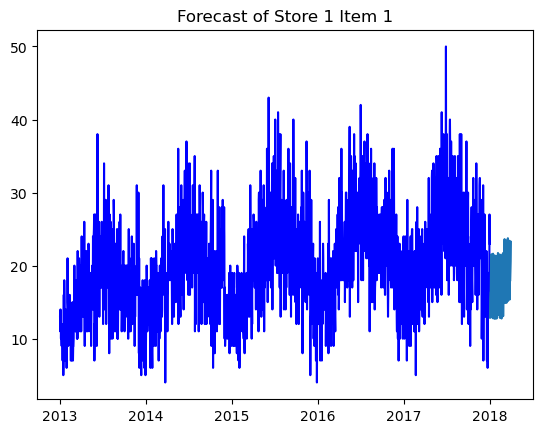

In [116]:
fig, ax = plt.subplots()
ax.plot(temp.sales, 'blue')
ax.plot(p.prediction)

ax.set(title='Forecast of Store 1 Item 1')
plt.show()

Looping through all

In [ ]:
results = []
tr_start,tr_end = '2015-01-01','2017-09-30'
te_start,te_end = '2017-10-01','2017-12-31'
for i in range(1,51):
    for s in range(1,11):
        buf = df[(df.item==i)&(df.store==s)].copy()
        target_exog = buf[te_start:].drop(['id','store','item','sales'],axis = 1)#exog for predict.
        
        #train_test_split
        tra = buf['sales'][tr_start:tr_end]#.dropna()
        tes = buf['sales'][te_start:te_end]#.dropna()
        exog_train = buf.drop(['id','store','item','sales'],axis = 1)[tr_start:tr_end]#.dropna()
        exog_train = exog_train.astype(int)
        #fitting
        mod = SARIMAX(tra,order=(6,1,7),seasonal_order=(0,0,0,0),exog = exog_train,freq='D',
                                       enforce_stationarity=False, enforce_invertibility=False).fit()
        
        target_exog = target_exog.astype(int) 
        pred = mod.get_prediction(tr_end,'2018-03-31',exog =target_exog)
        results.extend(pred.predicted_mean['2018-01-01':])
        print('item:',i,'store:',s,'Finished.')

item: 1 store: 1 Finished.
item: 1 store: 2 Finished.
item: 1 store: 3 Finished.
item: 1 store: 4 Finished.
item: 1 store: 5 Finished.
item: 1 store: 6 Finished.
item: 1 store: 7 Finished.
item: 1 store: 8 Finished.
item: 1 store: 9 Finished.
item: 1 store: 10 Finished.
item: 2 store: 1 Finished.
item: 2 store: 2 Finished.
item: 2 store: 3 Finished.
item: 2 store: 4 Finished.
item: 2 store: 5 Finished.
item: 2 store: 6 Finished.
item: 2 store: 7 Finished.
item: 2 store: 8 Finished.
item: 2 store: 9 Finished.
item: 2 store: 10 Finished.
item: 3 store: 1 Finished.
item: 3 store: 2 Finished.
item: 3 store: 3 Finished.
item: 3 store: 4 Finished.
item: 3 store: 5 Finished.
item: 3 store: 6 Finished.
item: 3 store: 7 Finished.
item: 3 store: 8 Finished.
item: 3 store: 9 Finished.
item: 3 store: 10 Finished.
item: 4 store: 1 Finished.
item: 4 store: 2 Finished.
item: 4 store: 3 Finished.
item: 4 store: 4 Finished.
item: 4 store: 5 Finished.
item: 4 store: 6 Finished.
item: 4 store: 7 Finished

item: 30 store: 6 Finished.
item: 30 store: 7 Finished.
item: 30 store: 8 Finished.
item: 30 store: 9 Finished.
item: 30 store: 10 Finished.
item: 31 store: 1 Finished.
item: 31 store: 2 Finished.
item: 31 store: 3 Finished.
item: 31 store: 4 Finished.
item: 31 store: 5 Finished.
item: 31 store: 6 Finished.
item: 31 store: 7 Finished.
item: 31 store: 8 Finished.
item: 31 store: 9 Finished.
item: 31 store: 10 Finished.
item: 32 store: 1 Finished.
item: 32 store: 2 Finished.
item: 32 store: 3 Finished.
item: 32 store: 4 Finished.
item: 32 store: 5 Finished.
item: 32 store: 6 Finished.
item: 32 store: 7 Finished.
item: 32 store: 8 Finished.
item: 32 store: 9 Finished.
item: 32 store: 10 Finished.
item: 33 store: 1 Finished.
item: 33 store: 2 Finished.
item: 33 store: 3 Finished.
item: 33 store: 4 Finished.
item: 33 store: 5 Finished.
item: 33 store: 6 Finished.
item: 33 store: 7 Finished.
item: 33 store: 8 Finished.
item: 33 store: 9 Finished.
item: 33 store: 10 Finished.
item: 34 store: 

In [ ]:
sample['sales'] = results
sample.to_csv('submission.csv',index=False)